In [5]:
import sys
new_paths = ['../datasets', '../utils','../Passive_Sampling']
for path in new_paths:
    sys.path.insert(0, path)
import warnings
warnings.filterwarnings("ignore")

#Basics
import numpy as np
from tqdm import tqdm
import pandas as pd
import scipy.io
import h5py
from plots import generate_barplots_regression, generate_lineplots_analysis
from Datasets_Class import Dataset
import random
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import spearmanr, pearsonr

# Sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, pairwise_distances
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

# Data selection strategies
from farthest_point import fps
from sklearn_extra.cluster import KMedoids
from apricot import FacilityLocationSelection

# 1. Download and Read Data
The 'Dataset' class can be used to download and read the datasets. It takes as input the path to the folder where the datasets will be downloaded. Once you have created the 'Dataset' class object, you can use the QM7_dataset, QM8_dataset, QM9_dataset modules to access the respective datasets. The modules download the respective datasets, preprocess them as described in the paper, and return a data feature matrix 'x' and associated labels 'y'.

In [6]:
datasets =  Dataset('../datasets')
x, y = datasets.QM7_dataset()
print('Shape data matrix:', x.shape)

Shape data matrix: (7165, 529)


# 2. Data Selection
Select data using FPS and other benchmark strategies

In [7]:

# Set random initial condition and define training set sizes
initial_conditions = [0,100,2000,3000,4000]
trainig_set_sizes = [int((len(x)/100)*c) for c in [1,3, 5, 7, 10]]


In [8]:
f = h5py.File("./Passive_sampling_QM7", "w")

print('Running FPS...')
grp = f.create_group(f'FPS')
for count, init in  enumerate(initial_conditions,1):
    subgrup_train = grp.create_group(f'train_Initialize_{count}')
    subgrup_test = grp.create_group(f'test_Initialize_{count}')
    idx_fps=  fps(x, [init], max(trainig_set_sizes))
    idx_test = list(np.arange(x.shape[0]))
    for n in trainig_set_sizes:
        idx_train = idx_fps[:n]
        idx_test_selected=  list(set(idx_test).difference(idx_train)) 
        subgrup_train.create_dataset(f'selected_{n}', data = idx_train) 
        subgrup_test.create_dataset(f'selected_{n}', data = idx_test_selected)

print('Running k-medoids++...')
grp = f.create_group(f'k-medoids++')
for count, init in  enumerate(initial_conditions,1):
    subgrup_train = grp.create_group(f'train_Initialize_{count}')
    subgrup_test = grp.create_group(f'test_Initialize_{count}')
    idx_test = list(np.arange(x.shape[0]))
    for n in trainig_set_sizes:
        kmedoids = KMedoids(n_clusters=n, init = 'k-medoids++', metric = 'euclidean', random_state=count).fit(x)
        select_idx =list(kmedoids.medoid_indices_)
        idx_train = select_idx
        idx_test_selected=  list(set(idx_test).difference(idx_train)) 
        subgrup_train.create_dataset(f'selected_{n}', data = idx_train) 
        subgrup_test.create_dataset(f'selected_{n}', data = idx_test_selected)
            
print('Running FacilityLocation...')
grp = f.create_group(f'FacilityLocation')
for count, init in  enumerate(initial_conditions,1):
    subgrup_train = grp.create_group(f'train_Initialize_{count}')
    subgrup_test = grp.create_group(f'test_Initialize_{count}')   
    selector = FacilityLocationSelection(max(trainig_set_sizes) , 'euclidean', initial_subset= [init])
    selector.fit(x)
    idx_slctd = selector.ranking
    idx_test = list(np.arange(x.shape[0]))
    for n in trainig_set_sizes:
            idx_train =  idx_slctd[:n]
            idx_test_selected =  list(set(idx_test).difference(idx_train))  
            subgrup_train.create_dataset(f'selected_{n}', data = idx_train) 
            subgrup_test.create_dataset(f'selected_{n}', data = idx_test_selected)
            
print('Running Radnom selection...')
grp = f.create_group(f'RDM')
for i in range(len(initial_conditions)):
        j = i+1
        random.seed(j)
        subgrup_train = grp.create_group(f'train_Initialize_{j}')
        subgrup_test = grp.create_group(f'test_Initialize_{j}')
        last = 0
        idx_train = []
        idx_test = list(np.arange(x.shape[0]))
        for n in trainig_set_sizes:
            n_ = n - last
            idx_train += random.sample(idx_test,n_)
            idx_test = list(set(idx_test).difference(idx_train))
            last = n 
            subgrup_train.create_dataset(f'selected_{n}', data = idx_train) 
            subgrup_test.create_dataset(f'selected_{n}', data = idx_test)
f.close()

Running FPS...


  0%|          | 0/715 [00:00<?, ?it/s]

100%|██████████| 715/715 [00:00<00:00, 11545.57it/s]


Running k-medoids++...
Running FacilityLocation...
Running Radnom selection...


# 3. Molecular Property Prediction: KRR with Gaussian Kernel

### 3.1 Hyperparameters grid-search on random data

In [9]:


f = h5py.File("./Passive_sampling_QM7", "r")
sampling_strategies=  ['FPS', 'FacilityLocation',  'RDM', 'k-medoids++' ]
hyperparameters = {'num_selected' : [],'alpha':  [], 'gamma' : []}

for size in tqdm(trainig_set_sizes):

    train_tags = f['RDM']['train_Initialize_1'][f'selected_{size}'][:]
    
    krr = KernelRidge()
    alpha = np.logspace(-14, -2, 12)
    gamma = np.logspace(-14, -2, 12)
    
    #Parameters grid
    parameters = { 'alpha':alpha, 'kernel':['rbf'], 'gamma':gamma}

    #Cross Validation
    clf = GridSearchCV(krr, parameters, cv=5, scoring = 'neg_mean_absolute_error',  verbose=0, n_jobs = 1)
    clf.fit(x[train_tags,:],y[train_tags])
    
    #Select best parameters
    alpha = clf.best_params_['alpha'] 
    gamma = clf.best_params_['gamma'] 
    
    #Save best parameters
    hyperparameters['num_selected'].append(size)
    hyperparameters['alpha'].append(alpha)
    hyperparameters['gamma'].append(gamma)

f.close()
hyperparameters_df = pd.DataFrame(data=hyperparameters)

100%|██████████| 5/5 [01:15<00:00, 15.12s/it]


### 3.2 Regression task

In [10]:
f = h5py.File("./Passive_sampling_QM7", "r")
alpha = hyperparameters_df['alpha'].mean()
gamma = hyperparameters_df['gamma'].mean()

d_a = {'strategy' : [], 'initialization' : [], 'num_selected' : [],  'MAE':  [],  'MAXAE' : [] }

for size in tqdm(trainig_set_sizes):
    for ss in sampling_strategies:
        for init in [1,2,3,4,5]:
                
                    #Load indeces training and test set   
                    idx_train = f[ss][f'train_Initialize_{init}'][f'selected_{size}'][:]
                    idx_test = f[ss][f'test_Initialize_{init}'][f'selected_{size}'][:]
                
                    #Regression
                    krr = KernelRidge(alpha=alpha, kernel= 'rbf', gamma =gamma )
                    krr.fit(x[idx_train,:], y[idx_train]) 
      
                    #Prediction and errors computation
                    ypred = krr.predict(X=x[idx_test,:])
                    MAE = mean_absolute_error(y[idx_test], ypred) 
                    MAXAE = max_error(y[idx_test], ypred)
                     
                    
                    # Save results in dictionary
                    d_a['strategy'].append(ss)
                    d_a['initialization'].append(init)
                    d_a['num_selected'].append(size)
                    d_a['MAE'].append(MAE)
                    d_a['MAXAE'].append(MAXAE)

df = pd.DataFrame(data=d_a)
f.close()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


### 3.2.1 Plot results regression

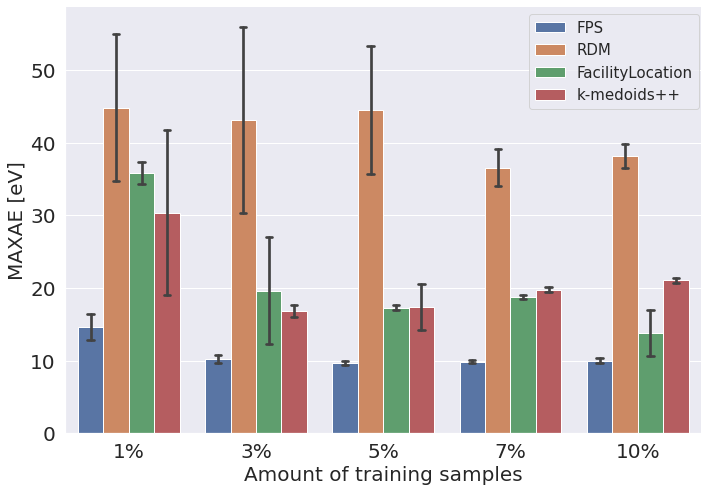

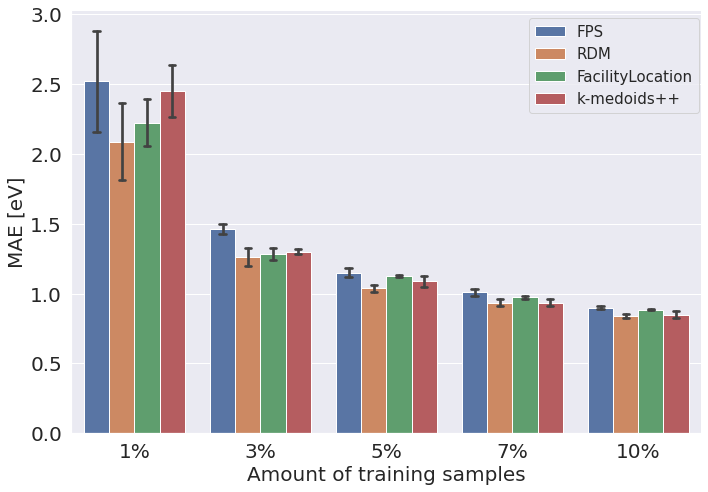

In [11]:
# Fig. 1(a)
generate_barplots_regression('QM7', df)

## 3.2.2 Plots fill distances of the selected training set and Condition numbers of computed Gaussian Kernels


In [12]:

f = h5py.File("./Passive_sampling_QM7", "r")
d_a = {'strategy' : [], 'initialization' : [], 'num_selected' : [],  'fill distance':  [], 'regularized condition number' : [], 'condition number' : [] }

for size in tqdm(trainig_set_sizes):
    for ss in sampling_strategies:
        for init in [1,2,3,4,5]:
                
                    #Load indeces training and test set   
                    idx_train = f[ss][f'train_Initialize_{init}'][f'selected_{size}'][:]
                    idx_test = f[ss][f'test_Initialize_{init}'][f'selected_{size}'][:]
                    
                    krr = KernelRidge(alpha=alpha, kernel= 'rbf', gamma =gamma )
                    Kernel =  krr._get_kernel(x[idx_train])
                 
                    # Compute regularized condition number
                    singular_values = np.linalg.svd(Kernel + alpha*np.eye(len(Kernel)) , compute_uv=False)
                    lambda_max = np.max(singular_values)
                    lambda_min = np.min(singular_values)
                    regularized_condition_number = lambda_max/lambda_min 
                
                    # Compute condition number
                    singular_values = np.linalg.svd(Kernel, compute_uv=False)
                    lambda_max = np.max(singular_values)
                    lambda_min = np.min(singular_values)
                    condition_number = lambda_max/lambda_min 
                    
                    # Fill distance
                    dist =  pairwise_distances(x[idx_test,:],x[idx_train,:], n_jobs = -1)
                    fill = np.amax(np.amin(dist, axis = 1))                     
                    
                    # Save results in dictionary
                    d_a['strategy'].append(ss)
                    d_a['initialization'].append(init)
                    d_a['num_selected'].append(size)
                    d_a['fill distance'].append(fill)
                    d_a['regularized condition number'].append(regularized_condition_number)
                    d_a['condition number'].append(condition_number)

df_analysis = pd.DataFrame(data=d_a)
f.close()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [12:49<00:00, 153.96s/it]


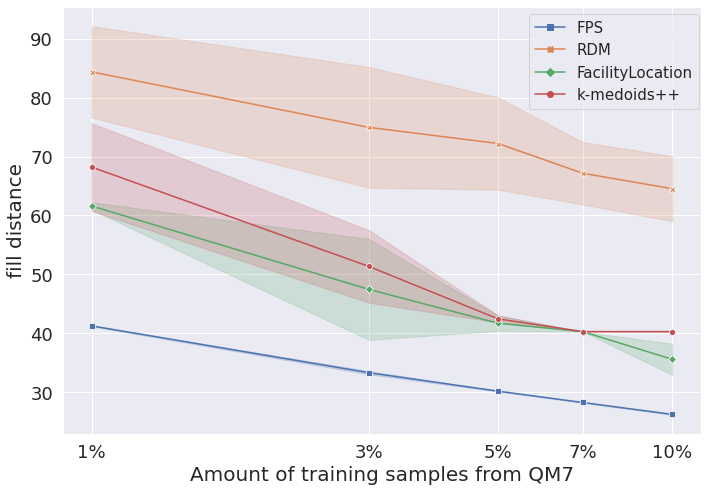

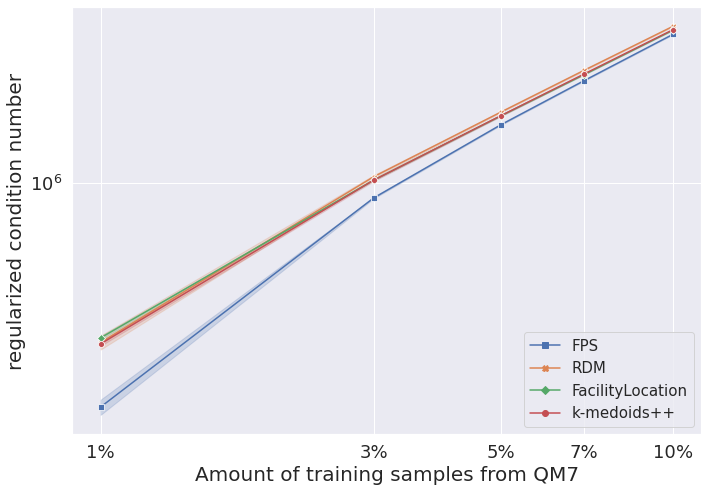

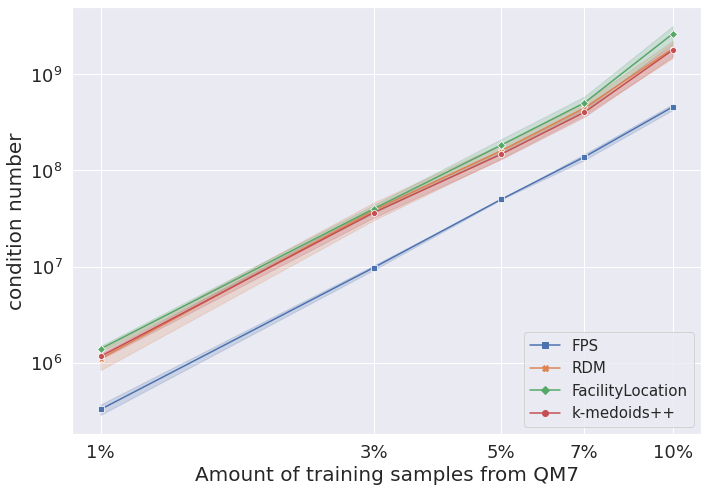

In [13]:
# Figs 4(a) Top row and 3(a)
generate_lineplots_analysis(df_analysis)

# 4. Empirical analysis

We reproduce the plots related to the empirical analysis on the QM7, reported in our paper.

## 4.1 Distribution of the data and selected data points

In [14]:

# Compute distance matrix
distance_matrix = pairwise_distances(x, metric='euclidean', n_jobs=-1)

# Remove zeros from diagonal
for i in range(distance_matrix.shape[0]):
    distance_matrix[i][i] = np.inf

# Calculate minimum distances and clean up memory
min_distance = np.min(distance_matrix, axis=1)
del distance_matrix

# Sort the indices of minimum distances in descending order
sorted_min_distance_indices = np.argsort(min_distance)[::-1]

Figs 4(b), 3(c) Top row

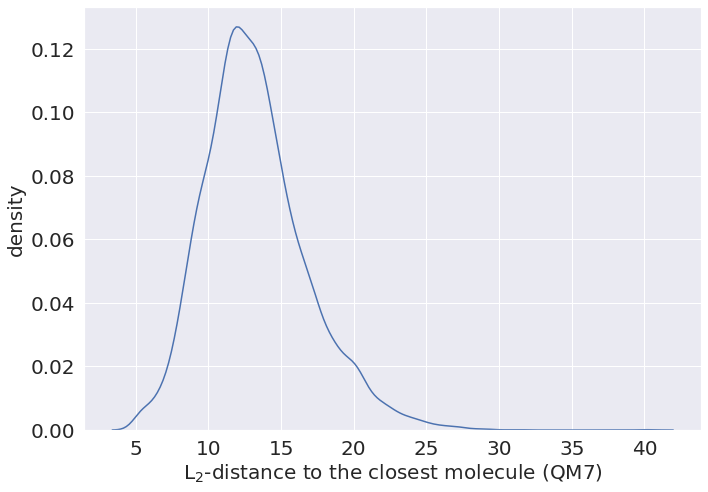

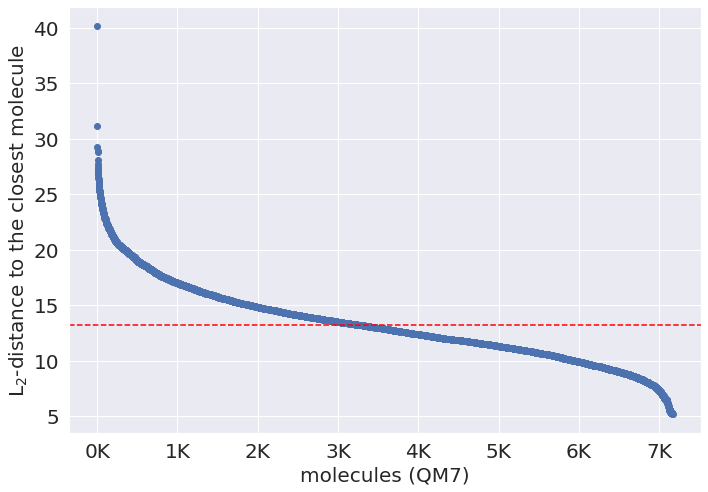

In [15]:

# Define a function for formatting ticks
def format_fn(value, tick_number):
    return f"{value/1000:.0f}K" 

# Create the plot with line plot and density plot
fig, ax = plt.subplots(figsize=(10, 7))
sns.kdeplot(min_distance[sorted_min_distance_indices], label='Density Line')
ax.set_xlabel(r'L$_2$-distance to the closest molecule (QM7)', fontsize=20)
ax.set_ylabel('density', fontsize=20)
ax.tick_params(labelsize=20)
plt.tight_layout()
plt.show()
plt.close()

# Create a new plot with scatter plot and a horizontal line at the mean distance
fig, ax = plt.subplots(figsize=(10, 7))
x_axis = np.linspace(1, sorted_min_distance_indices.shape[0], sorted_min_distance_indices.shape[0])
ax.scatter(x_axis, min_distance[sorted_min_distance_indices])
ax.axhline(y=np.mean(min_distance[sorted_min_distance_indices]), color='red', linestyle='--')
ax.set_xlabel('molecules (QM7)', fontsize=20)
ax.set_ylabel(r'L$_2$-distance to the closest molecule', fontsize=20)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_fn))
ax.tick_params(labelsize=20)
plt.tight_layout()
plt.show()
plt.close()

Fig. 5 Top row.

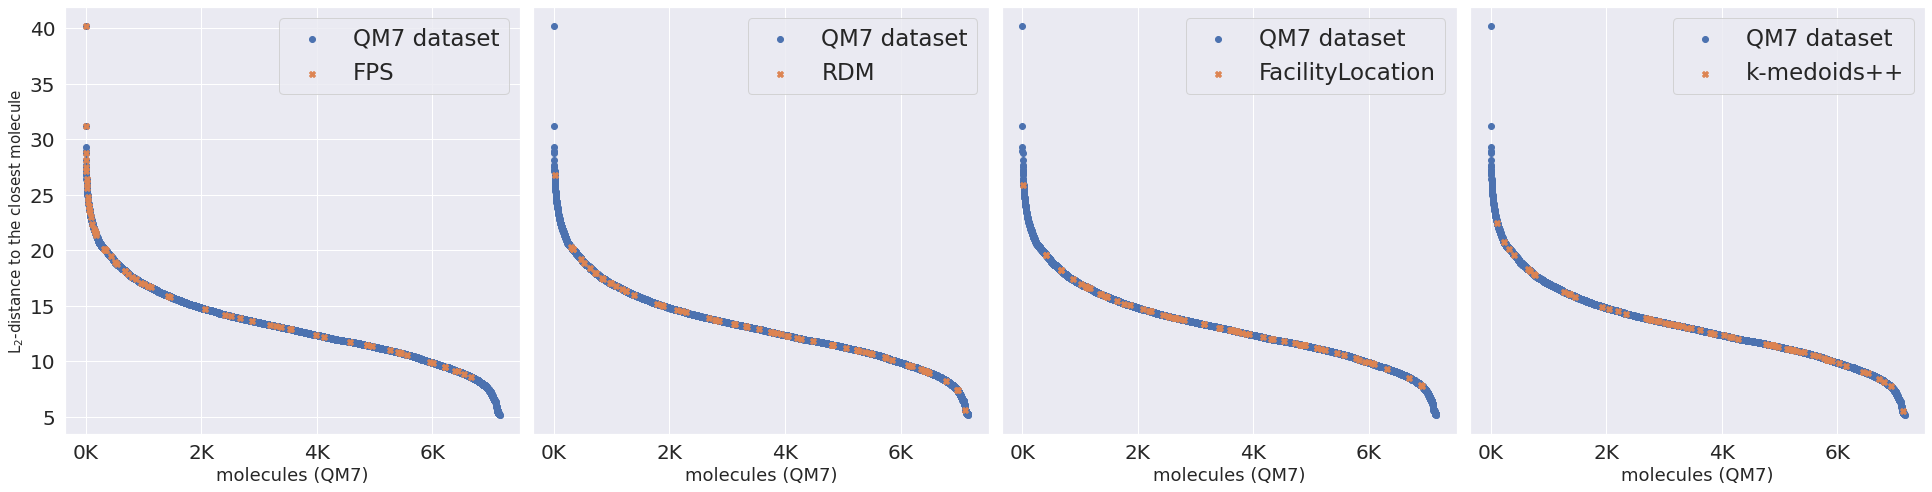

In [16]:

f = h5py.File('./Passive_sampling_QM7', "r")
# Define parameters
sampling_strategies = ['FPS', 'RDM', 'FacilityLocation', 'k-medoids++']
selected_sizes = [int(len(x) / 100 * 1)]

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(27, 7))

# Iterate over selected sizes
for size in selected_sizes:
    # Iterate over sampling strategies
    for count, ss in enumerate(sampling_strategies):
      
            # Retrieve data from the HDF5 file
            idx_train = f[ss][f'train_Initialize_2'][f'selected_{size}'][:]
            indices_selected = [i for i, x in enumerate(sorted_min_distance_indices) if x in idx_train]

            # Plot data
            axs[count].scatter(x_axis, min_distance[sorted_min_distance_indices], label='QM7 dataset', marker="o")
            axs[count].scatter(x_axis[indices_selected],
                               min_distance[sorted_min_distance_indices[indices_selected]], label=f'{ss}', marker='X')

            # Customize plot appearance
            axs[count].xaxis.set_major_formatter(ticker.FuncFormatter(format_fn))
            axs[count].set_xlabel('molecules (QM7)', fontsize=18)
            if count == 0:
                axs[count].set_ylabel(r'L$_2$-distance to the closest molecule', fontsize=15)
            else:
                axs[count].set_yticks([])
            axs[count].tick_params(labelsize=20)
            axs[count].legend(loc='upper right', prop={'size': 23})
        
# Configure overall plot appearance
fig = plt.gcf()
fig.set_clip_box([0, 0, 1, 1])
plt.tight_layout()

# Close the HDF5 file
f.close()

## 4.2 Importance of the data assumptions 
Compute Pearson's and Spearman's correlation coefficients. We expect the pairwise distances in feature and label space to be directly correlated for the experiments to ensure consistency with theory.

In [17]:
#Extracts the upper triangular elements from a matrix.
def upper_triangular(matrix):
    rows, cols = matrix.shape
    upper_diagonal_array = []
    for i in range(rows):
        for j in range(i + 1, cols):
            upper_diagonal_array.append(matrix[i, j])     
    upper_diagonal_array = np.array(upper_diagonal_array)
    return upper_diagonal_array

# Calculate pairwise distances for matrices x and y
dist_x = pairwise_distances(x, n_jobs=-1)
ut_x = upper_triangular(dist_x)

dist_y = pairwise_distances(y[:, np.newaxis], y[:, np.newaxis], n_jobs=-1)
ut_y = upper_triangular(dist_y)

# Calculate Spearman and Pearson correlation coefficients
pearson_cc, pearson_p_value = pearsonr(ut_x, ut_y)
spearman_cc, spearman_p_value = spearmanr(ut_x, ut_y)


# Print the correlation coefficients
print('Pearson correlation coefficient with atomization energy labels:', pearson_cc)
print('Spearman correlation coefficient with atomization energy labels:', spearman_cc)


Pearson correlation coefficient with atomization energy labels: 0.14943377066178745
Spearman correlation coefficient with atomization energy labels: 0.2811063119207746
